# Feb 6th, 2022 (rabies: 3rd stage)

**Motivation**: Organize files shared by Gabe.  Includes clean time series, brain masks per run, and temporal masks. ***NEW***: Reorient? ***Latest*** Mask mismatch? Crop? **Update 13th**: Realized masks are somewhat different, need to run CCF registration again. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice((128, 0))
mice.setup_anat_data()

meta_dir = pjoin(mice.cfg.base_dir, 'meta_info')
cwd = pjoin(mice.cfg.download_dir, 'native_mot6_FD_DVARS_WM_CSF')
os.listdir(cwd)

['native_brain_mask', 'confound_correction_wf_datasink']

## m200

In [3]:
m200 = mice.mask3d['sub-SLC04_ses-2'].load_ants()
m200

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [9]:
_dir = '/home/hadi/Downloads'
f = 'sub-SLC04_ses-2_task-led_run-2_bold_EPI_brain_mask.nii.gz'
f = pjoin(_dir, f) 
m200_rabies = ants.image_read(f)
m200_rabies

ANTsImage (LPI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 90, 53)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (19.0, 7.9, -4.65)
         Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [10]:
m200_rabies = m200_rabies.numpy()

In [11]:
ants.image_header_info(f)

{
    'pixelclass': 'scalar',
    'pixeltype': 'short',
    'nDimensions': 3,
    'nComponents': 1,
    'dimensions': (64.0, 90.0, 53.0),
    'spacing': (0.2, 0.2, 0.2),
    'origin': (19.0, 7.9, -4.65),
    'direction': array([[-1., -0.,  0.],
       [-0., -1.,  0.],
       [ 0.,  0.,  1.]])
}

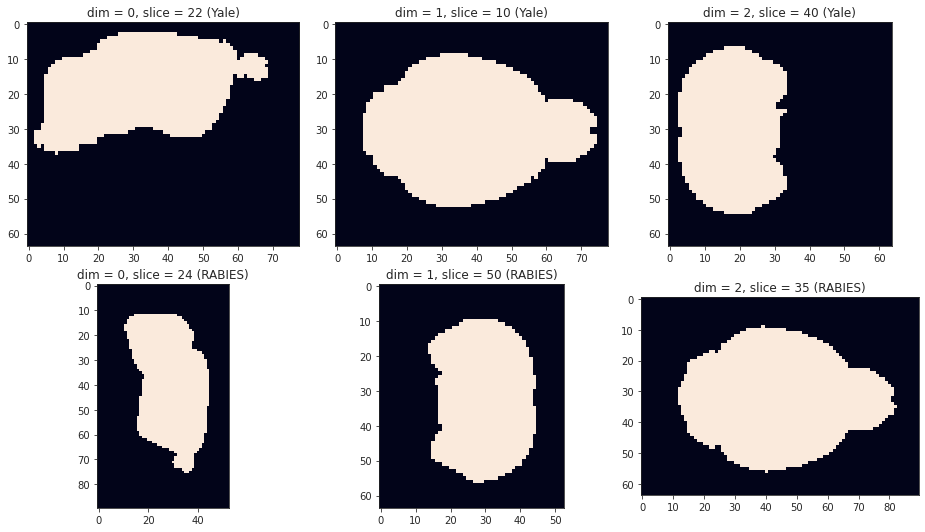

In [9]:
slices = [(22, 24), (10, 50), (40, 35)]

fig, axes = create_figure(2, 3, (13, 7.5))
for dim, (slice_yale, slice_gabe) in enumerate(slices):
    axes[0, dim].imshow(np.take(m200.numpy(), slice_yale, dim))
    axes[1, dim].imshow(np.take(m200_rabies, slice_gabe, dim))

    axes[0, dim].set_title(f'dim = {dim}, slice = {slice_yale} (Yale)')
    axes[1, dim].set_title(f'dim = {dim}, slice = {slice_gabe} (RABIES)')
plt.show()

In [10]:
m200_reor = np.transpose(m200_rabies, (0, 2, 1))
m200_reor = m200_reor[::-1][:, ::-1, :]

In [11]:
m200_rabies.shape, m200_reor.shape

((64, 90, 53), (64, 53, 90))

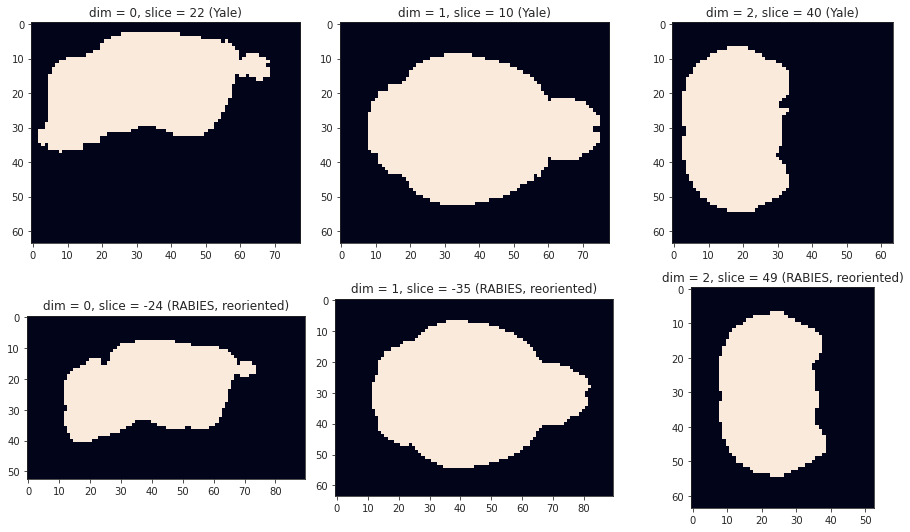

In [13]:
slices = [(22, -24), (10, -35), (40, 49)]

fig, axes = create_figure(2, 3, (13, 7.5))
for dim, (slice_yale, slice_gabe) in enumerate(slices):
    axes[0, dim].imshow(np.take(m200.numpy(), slice_yale, dim))
    axes[1, dim].imshow(np.take(m200_reor, slice_gabe, dim))

    axes[0, dim].set_title(f'dim = {dim}, slice = {slice_yale} (Yale)')
    axes[1, dim].set_title(f'dim = {dim}, slice = {slice_gabe} (RABIES, reoriented)')
plt.show()

### ANTs translation

In [14]:
from register.register import reset_ants_img

In [15]:
_dir = '/home/hadi/Downloads'
file = 'sub-SLC04_ses-2_task-led_run-2_bold_EPI_brain_mask.nii.gz'
file = pjoin(_dir, file)
m200_rabies = ants.image_read(file)
m200_rabies

ANTsImage (LPI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 90, 53)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (19.0, 7.9, -4.65)
         Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [16]:
m200_reor = np.transpose(m200_rabies.numpy(), (0, 2, 1))
m200_reor = m200_reor[::-1][:, ::-1, :]

In [17]:
m200_reor = reset_ants_img(
    img=m200_reor,
    spacing=m200_rabies.spacing,
    use_um=False,
)
m200_reor

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 53, 90)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [18]:
tr = ants.registration(
    fixed=m200_reor,
    moving=m200,
    type_of_transform='Translation',
)
warped = ants.apply_transforms(
    fixed=m200_reor,
    moving=m200,
    transformlist=tr['fwdtransforms'],
)
warped

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 53, 90)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

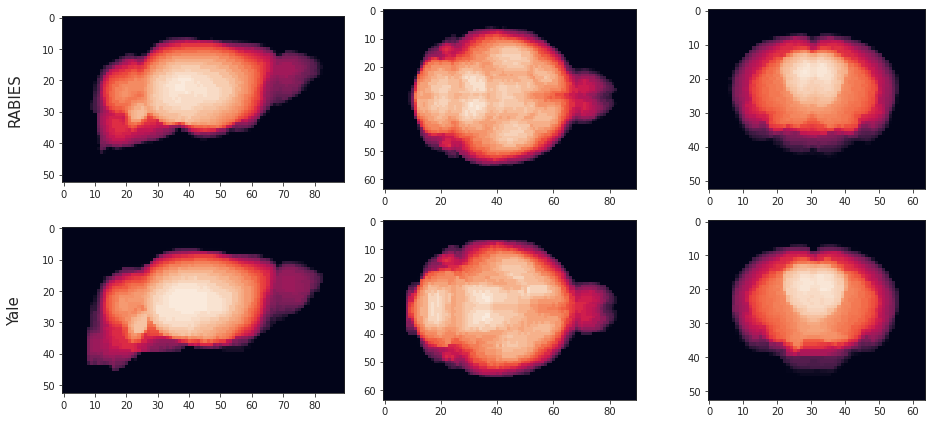

In [27]:
fig, axes = create_figure(2, 3, (13.5, 6))
for i in range(3):
    x2plt = m200_reor.mean(i)
    if i == 2:
        x2plt = x2plt.T
    axes[0, i].imshow(x2plt)
    
    x2plt = warped.mean(i)
    if i == 2:
        x2plt = x2plt.T
    axes[1, i].imshow(x2plt)
    
axes[0, 0].set_ylabel('RABIES', fontsize=15, labelpad=20)
axes[1, 0].set_ylabel('Yale', fontsize=15, labelpad=20)
plt.show()

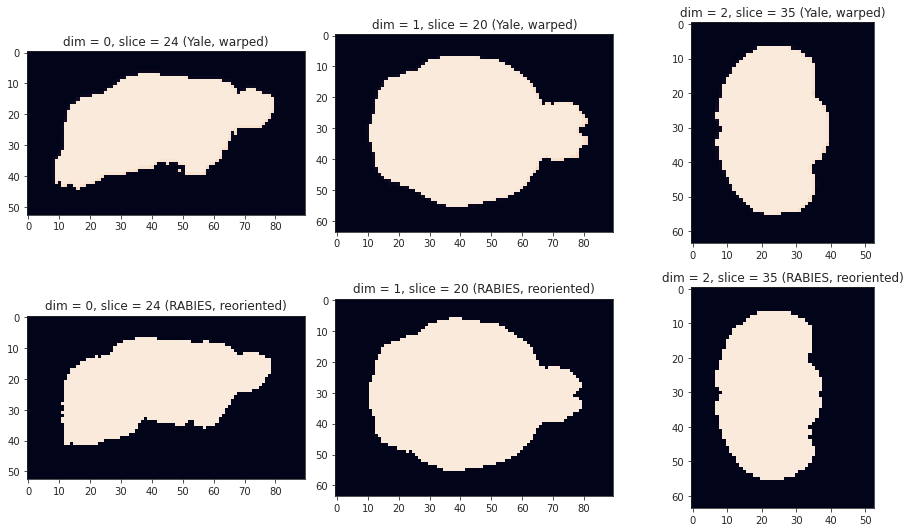

In [28]:
slices = [(24, 24), (20, 20), (35, 35)]

fig, axes = create_figure(2, 3, (13, 7.5))
for dim, (slice_yale, slice_gabe) in enumerate(slices):
    axes[0, dim].imshow(np.take(warped.numpy(), slice_yale, dim))
    axes[1, dim].imshow(np.take(m200_reor.numpy(), slice_gabe, dim))

    axes[0, dim].set_title(f'dim = {dim}, slice = {slice_yale} (Yale, warped)')
    axes[1, dim].set_title(f'dim = {dim}, slice = {slice_gabe} (RABIES, reoriented)')
plt.show()

In [20]:
file = 'sub-SLC04_ses-2_acq-isotropic_T1w.nii.gz'
file = pjoin(tmp_dir, file)
img = ants.image_read(file)
img

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7f101f0e3f70>

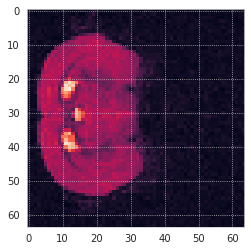

In [7]:
plt.imshow(img[..., 40])

<matplotlib.image.AxesImage object at 0x7f101ec2e8e0>

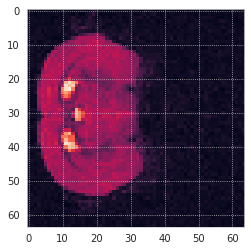

In [13]:
img2 = mice.T1w['sub-SLC04_ses-2'].load_ants()
plt.imshow(img2[..., 40])

In [22]:
img_nib = nib.load(file)
img_nib.affine

array([[-0.2       ,  0.        ,  0.        , -6.4000001 ],
       [ 0.        , -0.2       ,  0.        ,  6.20000029],
       [ 0.        ,  0.        ,  0.2       , -7.80000019],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [21]:
a = img_nib.get_header()

## New load (Feb 7, 14:57)

In [42]:
_dir = '/home/hadi/Downloads'
f = 'sub-SLC04_ses-2_space-individual_T1w.nii.gz'
f = pjoin(_dir, f) 
first = ants.image_read(f)
first

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [43]:
_dir = '/home/hadi/Downloads'
f = 'sub-SLC04_ses-2_acq-isotropic_T1w.nii.gz'
f = pjoin(_dir, f) 
isotropic_raw = ants.image_read(f)
isotropic_raw

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [44]:
_dir = '/home/hadi/Downloads'
f = 'Gabe_sub-SLC04_ses-2_acq-isotropic_T1w.nii.gz'
f = pjoin(_dir, f) 
isotropic = ants.image_read(f)
isotropic

ANTsImage (LPI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 78, 64)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (19.0, 6.4, -7.8)
         Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [45]:
_dir = '/home/hadi/Downloads'
f = 'Gabe_RAS_orig_anat.nii.gz'
f = pjoin(_dir, f) 
RAS = ants.image_read(f)
RAS

ANTsImage (LPI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (19.0, 6.4, -7.8)
         Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [46]:
_dir = '/home/hadi/Downloads'
f = 'Gabe_reorient3.nii.gz'
f = pjoin(_dir, f) 
reorient = ants.image_read(f)
reorient

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7fc98ecf3910>

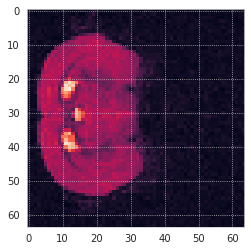

In [32]:
plt.imshow(isotropic_raw[..., 40])

<matplotlib.image.AxesImage object at 0x7fc98edaed60>

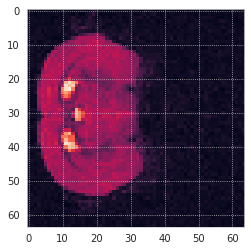

In [33]:
plt.imshow(reorient[..., 40])

## Edit Feb 13th

### Example 1

In [3]:
_dir = '/mnt/storage/hadi/Ca-fMRI/gabe_data'
f = 'sub-SLC03_ses-1_task-led_run-3_bold_combined_cleaned.nii.gz'
f = pjoin(_dir, 'reoriented_data/cleaned_timeseries', f) 
img = ants.image_read(f)
img

ANTsImage
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78, 323)
         Spacing    : (0.2, 0.2, 0.2, 1.0)
         Origin     : (6.4, -6.2, -7.8, 0.0)
         Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

In [14]:
f = 'sub-SLC03_ses-1_task-led_run-3_bold_EPI_brain_mask.nii.gz'
f = pjoin(_dir, 'reoriented_data/brain_mask', f) 
m = ants.image_read(f)
m

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [17]:
t1w = mice.T1w['sub-SLC03_ses-1'].load_ants()
t1w

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

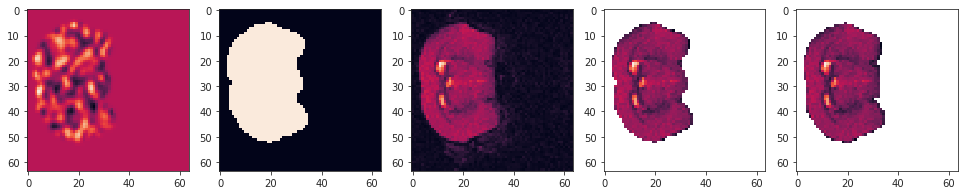

In [39]:
i = 45

fig, axes = create_figure(1, 5, (13.5, 2.8))

axes[0].imshow(img.numpy()[..., i, 100])
axes[1].imshow(m.numpy()[..., i])
axes[2].imshow(t1w.numpy()[..., i])

x2plt = np.ma.masked_where(m.numpy()[..., i] == 0, t1w.numpy()[..., i])
axes[3].imshow(x2plt)

x2plt = np.ma.masked_where(
    mice.mask3d['sub-SLC03_ses-1'].load_ants().numpy()[..., i] == 0, t1w.numpy()[..., i])
axes[4].imshow(x2plt)

plt.show()

### Example 2

In [43]:
_dir = '/mnt/storage/hadi/Ca-fMRI/gabe_data'
f = 'sub-SLC10_ses-1_task-rest_run-7_bold_combined_cleaned.nii.gz'
f = pjoin(_dir, 'reoriented_data/cleaned_timeseries', f) 
img = ants.image_read(f)
img

ANTsImage
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78, 547)
         Spacing    : (0.2, 0.2, 0.2, 1.0)
         Origin     : (6.4, -6.2, -7.8, 0.0)
         Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

In [44]:
f = 'sub-SLC10_ses-1_task-rest_run-7_bold_EPI_brain_mask.nii.gz'
f = pjoin(_dir, 'reoriented_data/brain_mask', f) 
m = ants.image_read(f)
m

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [45]:
t1w = mice.T1w['sub-SLC10_ses-1'].load_ants()
t1w

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

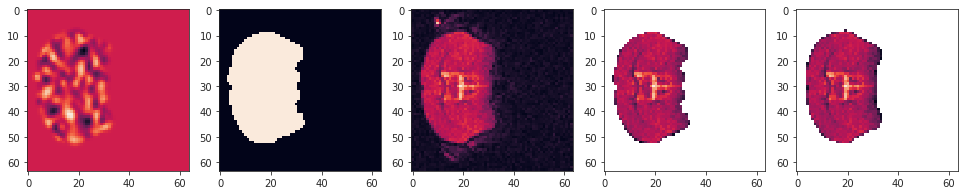

In [47]:
i = 45

fig, axes = create_figure(1, 5, (13.5, 2.8))

axes[0].imshow(img.numpy()[..., i, 100])
axes[1].imshow(m.numpy()[..., i])
axes[2].imshow(t1w.numpy()[..., i])

x2plt = np.ma.masked_where(m.numpy()[..., i] == 0, t1w.numpy()[..., i])
axes[3].imshow(x2plt)

x2plt = np.ma.masked_where(
    mice.mask3d['sub-SLC10_ses-1'].load_ants().numpy()[..., i] == 0, t1w.numpy()[..., i])
axes[4].imshow(x2plt)

plt.show()